In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import sys
import time

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
from utilities2015 import *
from metadata import *
from data_manager import *
from learning_utilities import *

/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Setting environment for AWS compute node


No vtk
File does not exist: /shared/CSHL_data_processed/MD635/MD635_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD635/MD635_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_anchor.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_sorted_filenames.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_cropbox.txt
File does not exist: /shared/CSHL_data_processed/MD657/MD657_cropbox.txt


In [3]:
from sklearn.externals import joblib

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier 

sys.path.append('/home/yuncong/csd395/xgboost/python-package')
try:
    from xgboost.sklearn import XGBClassifier
except:
    sys.stderr.write('xgboost is not loaded.')

xgboost is not loaded.

In [4]:
structures_to_sample = all_known_structures

negative_labels_to_sample = [s + '_negative' for s in structures_to_sample]

margins_to_sample = [500] # (200: 100 um, 500: 250 um)
surround_labels_to_sample = [convert_to_surround_name(s, margin=m, suffix=surr_l) 
                             for m in margins_to_sample
                             for s in structures_to_sample 
                             for surr_l in structures_to_sample + ['noclass'] 
                             if surr_l != s]

labels_to_sample = structures_to_sample + negative_labels_to_sample + surround_labels_to_sample + ['noclass']

# Train Classifiers

In [5]:
learning_setting_properties

,model,margin,train_set_id,neg_composition,sample_weighting
classifier_id,,,,,
99,gb2,500,98/99,neg_has_all_surround,unweighted


In [6]:
classifier_id = 99
classifier_properties = learning_setting_properties.loc[classifier_id]

margin = classifier_properties['margin']
model = classifier_properties['model']
sample_weighting = classifier_properties['sample_weighting']
neg_composition = classifier_properties['neg_composition']

In [7]:
# Load training dataset.

train_set_id_x = classifier_properties['train_set_id']
if isinstance(train_set_id_x, str) and '/' in train_set_id_x:
    # Use multiple training sets
    training_set_ids = map(int, train_set_id_x.split('/'))
    training_features, training_addresses = load_datasets(training_set_ids, labels_to_sample=labels_to_sample)
else:
    # Use a single training set
    training_features, training_addresses = load_datasets([train_set_id_x], labels_to_sample=labels_to_sample)
    
assert set(training_addresses.keys()) == set(training_features.keys()), \
    'Training features and training addresses are not consistent.'

In [8]:
labels_found = training_features.keys()
structures_found = set([convert_to_original_name(l) for l in labels_found]) - {'noclass'}

In [9]:
# Visualize training patches

# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
# display_images_in_grids(patches, nc=10)

# patches = extract_patches_given_locations_multiple_sections(training_addresses['12N_surround'][:10], 
#                                                             location_or_grid_index='grid_index',
#                                                             version='compressed')
# display_images_in_grids(patches, nc=10)

In [10]:
setting_dir = os.path.join(os.path.join(CLF_ROOTDIR, 'setting_%d' % classifier_id))

In [13]:
clf_dir = create_if_not_exists(os.path.join(setting_dir, 'classifiers'))

for structure in structures_found:

    print structure
    
    #############################
    ## Define Positive Samples ##
    #############################
    
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
    #############################
    ## Define Negative Samples ##
    #############################
    
#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')

    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
        
    ###########################
    ## Define Sample Weights ##
    ###########################
    
#     if setting == 9:
    if sample_weighting == 'weighted':
        neg_distances = np.concatenate([distances_to_structures[neg_class][structure] for neg_class in neg_classes])
            
        sample_weights_neg = np.ones((n_neg,))
        sample_weights_neg[neg_distances > thresh] = diminishing(neg_distances[neg_distances > thresh])
        sample_weights = np.r_[np.ones((n_pos,)), sample_weights_neg]
    else:
        sample_weights = None
    
    ###########################################################################################

    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
#     n_train = len(train_labels0)
#     ri = np.random.choice(range(n_train), size=100, replace=False)
#     train_data = train_data0[ri]
#     train_labels = train_labels0[ri]
    
    ##################
    ## Define Model ##
    ##################
    
#     if setting in [1, 2, 8, 9, 10, 11, 23, 24]:
    if model == 'lr':
        clf = LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, 
                                 fit_intercept=True, intercept_scaling=1, class_weight=None, 
                                 random_state=None, solver='liblinear', max_iter=100, multi_class='ovr', 
                                 verbose=0, warm_start=False, n_jobs=1)
            
#     elif setting == 3:
    elif model == 'lin_svc':
        clf = SVC(C=1.0, kernel='linear', degree=3, gamma='auto', coef0=0.0, shrinking=True, 
                  probability=True, tol=0.001, cache_size=1000, max_iter=-1,
              decision_function_shape=None, random_state=None)
        

#     elif setting == 4:
    elif model == 'lin_svc_calib':
        
        sv_uncalibrated = LinearSVC(penalty='l2', loss='squared_hinge', dual=True, tol=0.0001, 
                                C=1.0, multi_class='ovr', 
                                fit_intercept=True, intercept_scaling=1, max_iter=100)
        clf = CalibratedClassifierCV(sv_uncalibrated)
        
        
#     elif setting in [5]:        
    elif model == 'xgb1':
        clf = XGBClassifier(max_depth=3, learning_rate=0.2, n_estimators=200, 
                            silent=False, objective='binary:logistic', nthread=-1, gamma=0, 
                            min_child_weight=20, max_delta_step=0, subsample=.8, 
                            colsample_bytree=.8, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
                            scale_pos_weight=1, base_score=0.5, seed=0, missing=None)
        
#     elif setting in [6, 25]:
    elif model == 'gb1':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=200, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=3, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
#     elif setting in [7, 26]:     
    elif model == 'gb2':
        clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.3, n_estimators=100, 
                                         subsample=1., criterion='friedman_mse', 
                                         min_samples_split=50, min_samples_leaf=20, 
                                         min_weight_fraction_leaf=0.0, max_depth=5, 
                                         min_impurity_split=1e-07, init=None, random_state=None, 
                                         max_features=None, verbose=1, max_leaf_nodes=None, 
                                         warm_start=False, presort='auto')
        
    
    else:
        sys.stderr.write('Setting is not recognized.\n')

    
    t = time.time()    
    clf.fit(train_data, train_labels, sample_weight=sample_weights)
    sys.stderr.write('Fitting classifier: %.2f seconds\n' % (time.time() - t))

    clf_fp = os.path.join(clf_dir, '%(structure)s_clf_setting_%(setting)d.dump' % \
                                  dict(structure=structure, setting=classifier_id))
    
    joblib.dump(clf, clf_fp)
    
    transfer_data_synced(relative_to_ec2(clf_fp), 
                    from_hostname='ec2',
                    to_hostname='s3',
                    is_dir=False)

Tz
      Iter       Train Loss   Remaining Time 
         1           0.9214            2.82s
         2           0.7310            2.85s
         3           0.5859            2.89s
         4           0.4875            2.91s
         5           0.4175            2.90s
         6           0.3489            2.88s
         7           0.2984            2.84s
         8           0.2505            2.83s
         9           0.2088            2.80s
        10           0.1713            2.78s
        20           0.0376            2.49s
        30           0.0082            2.20s
        40           0.0019            1.89s
        50           0.0005            1.54s
        60           0.0004            1.04s
        70           0.0004            0.67s
        80           0.0004            0.39s
        90           0.0004            0.17s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Tz_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.59 seconds
Child returned 0
0.47 seconds.


Sp5O
      Iter       Train Loss   Remaining Time 
         1           1.0177            2.84s
         2           0.8420            2.82s
         3           0.7364            2.76s
         4           0.6295            2.79s
         5           0.5556            2.74s
         6           0.4760            2.73s
         7           0.4128            2.73s
         8           0.3614            2.73s
         9           0.3139            2.84s
        10           0.2788            2.79s
        20           0.0922            2.41s
        30           0.0309            2.11s
        40           0.0103            1.80s
        50           0.0034            1.49s
        60           0.0011            1.19s
        70           0.0005            0.87s
        80           0.0005            0.51s
        90           0.0005            0.23s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Sp5O_clf_setting_99.dump s3://mouseb

Fitting classifier: 2.05 seconds
Child returned 0
0.42 seconds.


7n
      Iter       Train Loss   Remaining Time 
         1           0.8660            2.48s
         2           0.6657            2.83s
         3           0.5393            2.85s
         4           0.4367            2.90s
         5           0.3645            2.81s
         6           0.3028            2.80s
         7           0.2489            2.83s
         8           0.2081            2.83s
         9           0.1744            2.80s
        10           0.1486            2.77s
        20           0.0259            2.52s
        30           0.0052            2.23s
        40           0.0011            1.90s
        50           0.0004            1.48s
        60           0.0003            1.00s
        70           0.0003            0.64s
        80           0.0003            0.38s
        90           0.0003            0.17s
       100           0.0003            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/7n_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.53 seconds
Child returned 0
0.42 seconds.


DC
      Iter       Train Loss   Remaining Time 
         1           0.8595            4.11s
         2           0.7138            4.23s
         3           0.6177            4.18s
         4           0.5191            4.15s
         5           0.4595            3.96s
         6           0.3905            3.98s
         7           0.3368            3.96s
         8           0.2872            3.97s
         9           0.2536            3.96s
        10           0.2208            3.89s
        20           0.0553            3.49s
        30           0.0166            3.03s
        40           0.0051            2.58s
        50           0.0014            2.16s
        60           0.0005            1.69s
        70           0.0004            1.09s
        80           0.0004            0.64s
        90           0.0004            0.28s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/DC_clf_setting_99.dump s3://mousebrain

Fitting classifier: 2.58 seconds
Child returned 0
0.42 seconds.


5N
      Iter       Train Loss   Remaining Time 
         1           1.0637            2.09s
         2           0.8789            2.19s
         3           0.7462            2.12s
         4           0.6306            2.10s
         5           0.5506            2.06s
         6           0.4660            2.03s
         7           0.4048            1.99s
         8           0.3532            1.96s
         9           0.2966            1.96s
        10           0.2599            1.93s
        20           0.0579            1.69s
        30           0.0141            1.48s
        40           0.0036            1.26s
        50           0.0010            1.05s
        60           0.0004            0.78s
        70           0.0004            0.50s
        80           0.0004            0.29s
        90           0.0004            0.13s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/5N_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.19 seconds
Child returned 0
0.42 seconds.


3N
      Iter       Train Loss   Remaining Time 
         1           1.0229            2.81s
         2           0.8617            2.87s
         3           0.7249            2.88s
         4           0.6155            2.87s
         5           0.5126            2.92s
         6           0.4442            2.95s
         7           0.3900            2.90s
         8           0.3361            2.88s
         9           0.2921            2.84s
        10           0.2612            2.79s
        20           0.0794            2.37s
        30           0.0251            2.07s
        40           0.0072            1.77s
        50           0.0022            1.48s
        60           0.0007            1.18s
        70           0.0005            0.79s
        80           0.0005            0.46s
        90           0.0005            0.21s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/3N_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.88 seconds
Child returned 0
0.42 seconds.


Pn
      Iter       Train Loss   Remaining Time 
         1           0.9465            3.61s
         2           0.7867            3.53s
         3           0.6617            3.41s
         4           0.5749            3.33s
         5           0.4967            3.37s
         6           0.4344            3.28s
         7           0.3754            3.24s
         8           0.3171            3.21s
         9           0.2864            3.15s
        10           0.2603            3.10s
        20           0.0705            2.81s
        30           0.0194            2.49s
        40           0.0065            2.13s
        50           0.0019            1.77s
        60           0.0006            1.42s
        70           0.0004            0.95s
        80           0.0004            0.56s
        90           0.0004            0.25s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Pn_clf_setting_99.dump s3://mousebrain

Fitting classifier: 2.25 seconds
Child returned 0
0.42 seconds.


10N
      Iter       Train Loss   Remaining Time 
         1           0.8020            3.56s
         2           0.6258            3.42s
         3           0.4966            3.58s
         4           0.4118            3.51s
         5           0.3414            3.55s
         6           0.2893            3.48s
         7           0.2387            3.48s
         8           0.2006            3.47s
         9           0.1670            3.46s
        10           0.1401            3.43s
        20           0.0289            3.13s
        30           0.0068            2.72s
        40           0.0016            2.34s
        50           0.0004            1.91s
        60           0.0004            1.29s
        70           0.0004            0.83s
        80           0.0004            0.49s
        90           0.0004            0.22s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/10N_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.98 seconds
Child returned 0
0.37 seconds.


LC
      Iter       Train Loss   Remaining Time 
         1           1.0764            1.25s
         2           0.8664            1.47s
         3           0.7188            1.53s
         4           0.5975            1.60s
         5           0.5081            1.59s
         6           0.4274            1.54s
         7           0.3556            1.52s
         8           0.3067            1.51s
         9           0.2605            1.50s
        10           0.2214            1.48s
        20           0.0454            1.32s
        30           0.0095            1.17s
        40           0.0023            1.02s
        50           0.0005            0.84s
        60           0.0004            0.58s
        70           0.0004            0.37s
        80           0.0004            0.22s
        90           0.0004            0.10s
       100           0.0004            0.00s


Fitting classifier: 0.89 seconds


aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/LC_clf_setting_99.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/LC_clf_setting_99.dump


Child returned 0
0.42 seconds.


7N
      Iter       Train Loss   Remaining Time 
         1           1.1306            1.88s
         2           0.9312            2.04s
         3           0.7890            2.16s
         4           0.6827            2.08s
         5           0.5929            2.04s
         6           0.5096            1.96s
         7           0.4304            1.97s
         8           0.3759            1.95s
         9           0.3228            1.95s
        10           0.2757            1.94s
        20           0.0642            1.73s
        30           0.0177            1.52s
        40           0.0054            1.28s
        50           0.0015            1.06s
        60           0.0005            0.83s
        70           0.0005            0.54s
        80           0.0005            0.31s
        90           0.0005            0.14s
       100           0.0005            0.00s


Fitting classifier: 1.27 seconds


aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/7N_clf_setting_99.dump s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/7N_clf_setting_99.dump


Child returned 0
0.42 seconds.


Amb
      Iter       Train Loss   Remaining Time 
         1           0.8827            2.89s
         2           0.6815            3.05s
         3           0.5473            3.05s
         4           0.4528            3.00s
         5           0.3648            3.02s
         6           0.3035            3.01s
         7           0.2543            2.98s
         8           0.2061            2.98s
         9           0.1784            2.93s
        10           0.1506            2.91s
        20           0.0235            2.65s
        30           0.0045            2.30s
        40           0.0008            1.97s
        50           0.0004            1.44s
        60           0.0004            0.96s
        70           0.0004            0.62s
        80           0.0004            0.36s
        90           0.0004            0.16s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Amb_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.48 seconds
Child returned 0
0.41 seconds.


12N
      Iter       Train Loss   Remaining Time 
         1           0.7912            3.41s
         2           0.5950            3.62s
         3           0.4817            3.70s
         4           0.4005            3.67s
         5           0.3396            3.66s
         6           0.2773            3.68s
         7           0.2296            3.65s
         8           0.1898            3.62s
         9           0.1692            3.51s
        10           0.1412            3.49s
        20           0.0311            3.08s
        30           0.0080            2.68s
        40           0.0020            2.30s
        50           0.0005            1.89s
        60           0.0003            1.35s
        70           0.0003            0.87s
        80           0.0003            0.51s
        90           0.0003            0.23s
       100           0.0003            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/12N_clf_setting_99.dump s3://mousebra

Fitting classifier: 2.07 seconds
Child returned 0
0.42 seconds.


RMC
      Iter       Train Loss   Remaining Time 
         1           1.1186            1.50s
         2           0.9279            1.61s
         3           0.7831            1.60s
         4           0.6687            1.61s
         5           0.5869            1.60s
         6           0.5100            1.57s
         7           0.4437            1.56s
         8           0.3850            1.53s
         9           0.3336            1.51s
        10           0.2920            1.50s
        20           0.0792            1.32s
        30           0.0248            1.15s
        40           0.0071            0.98s
        50           0.0021            0.82s
        60           0.0006            0.66s
        70           0.0005            0.44s
        80           0.0005            0.26s
        90           0.0005            0.11s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/RMC_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.04 seconds
Child returned 0
0.42 seconds.


VCA
      Iter       Train Loss   Remaining Time 
         1           0.8786            3.99s
         2           0.7074            4.19s
         3           0.5889            4.11s
         4           0.5003            4.13s
         5           0.4281            4.10s
         6           0.3617            4.11s
         7           0.3108            4.05s
         8           0.2708            4.01s
         9           0.2361            3.94s
        10           0.2003            3.91s
        20           0.0496            3.47s
        30           0.0154            3.00s
        40           0.0044            2.57s
        50           0.0012            2.14s
        60           0.0004            1.64s
        70           0.0004            1.06s
        80           0.0004            0.62s
        90           0.0004            0.27s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/VCA_clf_setting_99.dump s3://mousebra

Fitting classifier: 2.50 seconds
Child returned 0
0.43 seconds.


Sp5I
      Iter       Train Loss   Remaining Time 
         1           0.9520            3.58s
         2           0.7597            4.13s
         3           0.6413            4.14s
         4           0.5837            3.93s
         5           0.5168            3.90s
         6           0.4390            3.94s
         7           0.3927            3.86s
         8           0.3460            3.88s
         9           0.3012            3.86s
        10           0.2695            3.81s
        20           0.0783            3.47s
        30           0.0254            3.01s
        40           0.0095            2.55s
        50           0.0033            2.12s
        60           0.0012            1.69s
        70           0.0005            1.24s
        80           0.0005            0.72s
        90           0.0005            0.32s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Sp5I_clf_setting_99.dump s3://mouseb

Fitting classifier: 2.92 seconds
Child returned 0
0.37 seconds.


Sp5C
      Iter       Train Loss   Remaining Time 
         1           0.9766            2.83s
         2           0.8061            3.16s
         3           0.6765            3.20s
         4           0.5708            3.21s
         5           0.4941            3.22s
         6           0.4230            3.20s
         7           0.3640            3.18s
         8           0.3201            3.17s
         9           0.2768            3.14s
        10           0.2436            3.13s
        20           0.0734            2.75s
        30           0.0239            2.40s
        40           0.0085            2.04s
        50           0.0028            1.69s
        60           0.0009            1.35s
        70           0.0005            0.96s
        80           0.0004            0.57s
        90           0.0004            0.25s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/Sp5C_clf_setting_99.dump s3://mouseb

Fitting classifier: 2.30 seconds
Child returned 0
0.37 seconds.


4N
      Iter       Train Loss   Remaining Time 
         1           0.9650            2.51s
         2           0.7588            2.82s
         3           0.6311            2.77s
         4           0.5145            2.76s
         5           0.4293            2.76s
         6           0.3591            2.78s
         7           0.3048            2.75s
         8           0.2588            2.71s
         9           0.2272            2.63s
        10           0.1939            2.59s
        20           0.0391            2.33s
        30           0.0098            2.01s
        40           0.0022            1.74s
        50           0.0005            1.43s
        60           0.0004            0.98s
        70           0.0004            0.63s
        80           0.0004            0.37s
        90           0.0004            0.16s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/4N_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.51 seconds
Child returned 0
0.37 seconds.


AP
      Iter       Train Loss   Remaining Time 
         1           0.7286            2.36s
         2           0.5527            3.01s
         3           0.4292            3.24s
         4           0.3500            3.32s
         5           0.2840            3.40s
         6           0.2377            3.38s
         7           0.1904            3.37s
         8           0.1579            3.31s
         9           0.1251            3.33s
        10           0.1019            3.32s
        20           0.0137            3.00s
        30           0.0024            2.60s
        40           0.0004            2.19s
        50           0.0003            1.52s
        60           0.0003            1.01s
        70           0.0003            0.65s
        80           0.0003            0.38s
        90           0.0003            0.17s
       100           0.0003            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/AP_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.56 seconds
Child returned 0
0.42 seconds.


PBG
      Iter       Train Loss   Remaining Time 
         1           0.8775            2.84s
         2           0.6796            2.89s
         3           0.5448            2.95s
         4           0.4550            2.96s
         5           0.3778            2.97s
         6           0.3156            2.89s
         7           0.2660            2.86s
         8           0.2176            2.84s
         9           0.1800            2.82s
        10           0.1489            2.80s
        20           0.0275            2.52s
        30           0.0059            2.21s
        40           0.0013            1.89s
        50           0.0004            1.51s
        60           0.0004            1.01s
        70           0.0004            0.65s
        80           0.0004            0.38s
        90           0.0004            0.17s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/PBG_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.54 seconds
Child returned 0
0.42 seconds.


LRt
      Iter       Train Loss   Remaining Time 
         1           1.0048            2.83s
         2           0.8405            2.93s
         3           0.7029            3.00s
         4           0.5871            3.03s
         5           0.5022            3.03s
         6           0.4313            3.01s
         7           0.3690            2.97s
         8           0.3236            2.94s
         9           0.2772            2.92s
        10           0.2391            2.90s
        20           0.0628            2.59s
        30           0.0171            2.27s
        40           0.0047            1.95s
        50           0.0014            1.62s
        60           0.0005            1.26s
        70           0.0005            0.82s
        80           0.0005            0.48s
        90           0.0005            0.21s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/LRt_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.94 seconds
Child returned 0
0.42 seconds.


IC
      Iter       Train Loss   Remaining Time 
         1           1.0709            2.92s
         2           0.9236            2.86s
         3           0.8005            2.81s
         4           0.6955            2.83s
         5           0.6001            2.82s
         6           0.5211            2.82s
         7           0.4587            2.80s
         8           0.4002            2.78s
         9           0.3475            2.77s
        10           0.3061            2.72s
        20           0.1001            2.35s
        30           0.0353            2.03s
        40           0.0125            1.75s
        50           0.0043            1.45s
        60           0.0014            1.17s
        70           0.0006            0.87s
        80           0.0005            0.52s
        90           0.0005            0.23s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/IC_clf_setting_99.dump s3://mousebrain

Fitting classifier: 2.09 seconds
Child returned 0
0.37 seconds.


VLL
      Iter       Train Loss   Remaining Time 
         1           0.9976            2.64s
         2           0.8065            2.70s
         3           0.6426            2.68s
         4           0.5293            2.67s
         5           0.4577            2.64s
         6           0.3878            2.64s
         7           0.3280            2.61s
         8           0.2752            2.57s
         9           0.2296            2.51s
        10           0.1929            2.50s
        20           0.0427            2.20s
        30           0.0092            1.91s
        40           0.0022            1.62s
        50           0.0006            1.33s
        60           0.0004            0.92s
        70           0.0004            0.59s
        80           0.0004            0.35s
        90           0.0004            0.15s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/VLL_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.41 seconds
Child returned 0
0.37 seconds.


VCP
      Iter       Train Loss   Remaining Time 
         1           0.9044            3.79s
         2           0.7633            3.83s
         3           0.6250            4.02s
         4           0.5360            3.94s
         5           0.4543            3.97s
         6           0.3978            3.89s
         7           0.3440            3.85s
         8           0.2986            3.80s
         9           0.2640            3.81s
        10           0.2304            3.77s
        20           0.0731            3.29s
        30           0.0233            2.89s
        40           0.0077            2.48s
        50           0.0029            2.04s
        60           0.0009            1.63s
        70           0.0004            1.16s
        80           0.0004            0.68s
        90           0.0004            0.30s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/VCP_clf_setting_99.dump s3://mousebra

Fitting classifier: 2.75 seconds
Child returned 0
0.37 seconds.


SNC
      Iter       Train Loss   Remaining Time 
         1           1.0127            2.63s
         2           0.8254            2.73s
         3           0.7048            2.76s
         4           0.5994            2.74s
         5           0.5021            2.72s
         6           0.4278            2.71s
         7           0.3661            2.70s
         8           0.3172            2.69s
         9           0.2707            2.67s
        10           0.2426            2.61s
        20           0.0585            2.33s
        30           0.0169            2.03s
        40           0.0049            1.75s
        50           0.0015            1.45s
        60           0.0005            1.14s
        70           0.0005            0.75s
        80           0.0005            0.44s
        90           0.0005            0.20s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/SNC_clf_setting_99.dump s3://mousebra

Fitting classifier: 1.78 seconds
Child returned 0
0.41 seconds.


6N
      Iter       Train Loss   Remaining Time 
         1           0.9218            2.69s
         2           0.7017            2.90s
         3           0.5600            2.93s
         4           0.4611            2.89s
         5           0.3786            2.84s
         6           0.3142            2.79s
         7           0.2658            2.74s
         8           0.2181            2.72s
         9           0.1798            2.70s
        10           0.1548            2.65s
        20           0.0276            2.37s
        30           0.0062            2.07s
        40           0.0013            1.77s
        50           0.0004            1.38s
        60           0.0004            0.92s
        70           0.0004            0.59s
        80           0.0004            0.35s
        90           0.0004            0.15s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/6N_clf_setting_99.dump s3://mousebrain

Fitting classifier: 1.42 seconds
Child returned 0
0.36 seconds.


SNR
      Iter       Train Loss   Remaining Time 
         1           0.7999            4.19s
         2           0.6607            4.47s
         3           0.5509            4.38s
         4           0.4609            4.41s
         5           0.3838            4.49s
         6           0.3430            4.33s
         7           0.2939            4.33s
         8           0.2586            4.23s
         9           0.2263            4.22s
        10           0.1966            4.22s
        20           0.0620            3.72s
        30           0.0192            3.28s
        40           0.0073            2.74s
        50           0.0024            2.30s
        60           0.0008            1.84s
        70           0.0004            1.30s
        80           0.0004            0.76s
        90           0.0004            0.34s
       100           0.0004            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/SNR_clf_setting_99.dump s3://mousebra

Fitting classifier: 3.06 seconds
Child returned 0
1.17 seconds.


SC
      Iter       Train Loss   Remaining Time 
         1           1.0485            3.17s
         2           0.9059            3.09s
         3           0.7961            2.96s
         4           0.6944            2.94s
         5           0.6202            2.85s
         6           0.5470            2.82s
         7           0.4869            2.77s
         8           0.4305            2.75s
         9           0.3761            2.73s
        10           0.3429            2.67s
        20           0.1131            2.40s
        30           0.0384            2.08s
        40           0.0153            1.77s
        50           0.0056            1.47s
        60           0.0021            1.18s
        70           0.0008            0.88s
        80           0.0005            0.54s
        90           0.0005            0.24s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/SC_clf_setting_99.dump s3://mousebrain

Fitting classifier: 2.21 seconds
Child returned 0
0.47 seconds.


RtTg
      Iter       Train Loss   Remaining Time 
         1           0.9291            4.30s
         2           0.7865            4.37s
         3           0.6782            4.42s
         4           0.5876            4.41s
         5           0.5185            4.35s
         6           0.4502            4.36s
         7           0.3908            4.27s
         8           0.3507            4.17s
         9           0.3237            4.04s
        10           0.2905            3.97s
        20           0.0935            3.43s
        30           0.0306            3.01s
        40           0.0115            2.57s
        50           0.0042            2.14s
        60           0.0016            1.71s
        70           0.0006            1.27s
        80           0.0005            0.77s
        90           0.0005            0.34s
       100           0.0005            0.00s
aws s3 cp /shared/CSHL_classifiers/setting_99/classifiers/RtTg_clf_setting_99.dump s3://mouseb

Fitting classifier: 3.11 seconds
Child returned 0
0.41 seconds.


# Load pre-computed classifiers

In [15]:
clf_allClasses = {}
for structure in structures_to_sample:
    clf_fp = os.path.join(setting_dir, 'classifiers', '%(structure)s_clf_setting_%(setting)d.dump' % {'structure': structure, 'setting':classifier_id})
    download_from_s3_if_not_exists(clf_fp)
    if os.path.exists(clf_fp):
        clf_allClasses[structure] = joblib.load(clf_fp)
    else:
        sys.stderr.write('Classifier for %s is not found.\n' % structure)

rm -rf /shared/CSHL_classifiers/setting_99/classifiers/sp5_clf_setting_99.dump && mkdir -p /shared/CSHL_classifiers/setting_99/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/sp5_clf_setting_99.dump /shared/CSHL_classifiers/setting_99/classifiers/sp5_clf_setting_99.dump


Child returned 0
Child returned 1
0.34 seconds.
Classifier for sp5 is not found.
Child returned 0


rm -rf /shared/CSHL_classifiers/setting_99/classifiers/outerContour_clf_setting_99.dump && mkdir -p /shared/CSHL_classifiers/setting_99/classifiers
aws s3 cp s3://mousebrainatlas-data/CSHL_classifiers/setting_99/classifiers/outerContour_clf_setting_99.dump /shared/CSHL_classifiers/setting_99/classifiers/outerContour_clf_setting_99.dump


Child returned 1
0.35 seconds.
Classifier for outerContour is not found.


In [22]:
margin = 500
neg_composition = 'neg_has_all_surround'

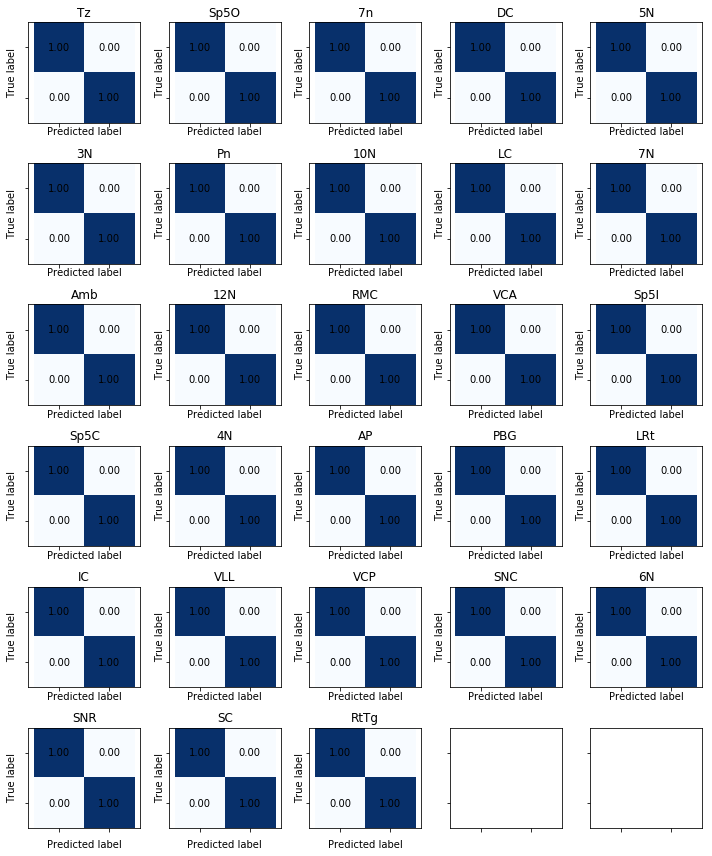

In [20]:
# Compute training accuracy

acc_all_structures = {}

ncols = 5
nrows = int(np.ceil(len(structures_found)/float(ncols)))

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2, nrows*2), sharex=True, sharey=True)
axes = axes.flatten()

for i, structure in enumerate(structures_found):
        
    features_pos = training_features[structure]
    n_pos = len(features_pos)
    
#     if setting in [1, 3, 4, 5, 6, 7]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
#         neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]            
#         for surr_l in structures_found:
#             c = convert_to_surround_name(structure, margin=margin, suffix=surr_l)
#             if c in labels_found:
#                 neg_classes.append(c)
#     elif setting in [8,9,11]:
#         neg_classes = [structure + '_negative']
#     else:
#         sys.stderr.write('Setting is not recognized.\n')
#         raise

#     if setting in [1, 3, 4, 5, 6, 7]:
    if neg_composition == 'neg_has_only_surround_noclass':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
#     elif setting in [2, 10, 23, 24, 25, 26]:
    elif neg_composition == 'neg_has_all_surround':
        neg_classes = [convert_to_surround_name(structure, margin=margin, suffix='noclass')]
        for surr_s in structures_found:
            c = convert_to_surround_name(structure, margin=margin, suffix=surr_s)
            if c in labels_found:
                neg_classes.append(c)
#     elif setting in [8,9,11]:
    elif neg_composition == 'neg_has_everything_else':
        neg_classes = [structure + '_negative']
    else:
        raise Exception('Setting is not recognized.')
        
        
    features_neg = np.concatenate([training_features[neg_class] for neg_class in neg_classes])
#     neg_distances = np.concatenate([distances_to_structures[neg_class][label] for neg_class in neg_classes])
        
    n_neg = len(features_neg)
    
    train_data = np.r_[features_pos, features_neg]
    train_labels = np.r_[np.ones((features_pos.shape[0], )), 
                         -np.ones((features_neg.shape[0], ))]
    
    clf = clf_allClasses[structure]
    
    probs = clf.predict_proba(train_data)[:, clf.classes_.tolist().index(1.)]
    cm = compute_confusion_matrix(np.c_[probs, 1-probs], [0 if l==1. else 1 for l in train_labels], soft=True)
    
    acc_all_structures[structure] = (n_pos*cm[0,0] + n_neg*cm[1,1])/(n_pos + n_neg)
    
    plot_confusion_matrix(cm, title='%(structure)s'% {'structure':structure},
                          labels=['',''],
#                           labels=[label, convert_to_surround_name(label)],
                         axis=axes[i])
#     plt.show();

plt.tight_layout()

In [21]:
print 'training accuracy:', np.mean(acc_all_structures.values())

training accuracy: 0.999783448578


In [34]:
def patch_boxes_overlay_on(bg, downscale_factor, locs, patch_size, colors=None, stack=None, sec=None):
    """
    Assume bg has the specified downscale_factor.
    """

    if bg == 'original':
        bg = imread(DataManager.get_image_filepath(stack=stack, section=sec, version='compressed'))[::downscale_factor, ::downscale_factor]
       
    # viz = bg.copy()
    viz = gray2rgb(bg).copy()
    # need copy() because of this bug http://stackoverflow.com/a/31316516
    
    half_size = patch_size/2/downscale_factor
    if isinstance(locs[0], list):
        if colors is None:
            colors = random_colors(len(locs))
        for i, locs_oneColor in enumerate(locs):
            for x, y in locs_oneColor:
                x = x / downscale_factor
                y = y / downscale_factor
                cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors[i], 2)
    else:
        if colors is None:
            colors = (255,0,0)
        for x, y in locs:
            x = x / downscale_factor
            y = y / downscale_factor
            cv2.rectangle(viz, (x-half_size, y-half_size), (x+half_size, y+half_size), colors, 2)
            
    return viz

In [35]:
# Visualize a patch in context

patch_size, stride, _, _ = get_default_gridspec('MD589')
grid_locations = grid_parameters_to_sample_locations(get_default_gridspec('MD589'))
viz = patch_boxes_overlay_on('original', 8, 
                       [grid_locations[44453]],
                      patch_size=patch_size,
                      stack='MD589',
                       sec=219)
display_image(viz)

/shared/MouseBrainAtlas/learning/tmp.jpg